In [1]:
import torch
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
import copy
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Cats_Dogs_Dataset(Dataset):
    """Cats_Dogs images dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = glob.glob(f'{root_dir}/*')
        self.labels = ['cat','dog']
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.files[idx]
        image = Image.open(img_name)
        
        if 'cat' in img_name.split("/")[-1]:
            label = torch.tensor(0, dtype=torch.long)
        else:
            label = torch.tensor(1, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [3]:
path_images = r"/storage/archive/dogs-vs-cats/train/"
os.listdir(path_images)[0:5]

['dog.10425.jpg',
 'cat.2462.jpg',
 'dog.5699.jpg',
 'cat.11828.jpg',
 'dog.10985.jpg']

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.488, 0.447, 0.409],
                             std=[0.2559, 0.2477, 0.249])
    ])

In [5]:
cats_dogs_dataset = Cats_Dogs_Dataset(root_dir=path_images, transform=data_transform)

In [6]:
def unnormelize(tensor):
    mean = torch.tensor([0.488, 0.447, 0.409])
    std = torch.tensor([0.2559, 0.2477, 0.249])
    if len(tensor.shape) == 3:
        mean = mean.reshape(3,1,1)
        std = std.reshape(3,1,1)
    elif len(tensor.shape) == 4:
        mean = mean.reshape(1,3,1,1)
        std = std.reshape(1,3,1,1)

    return tensor * std + mean	# The normalize code -> t.sub_(m).div_(s)

length of dataset is: 25000
Y PROPERTIES tensor(0)
X PROPERTIES torch.Size([3, 128, 128])


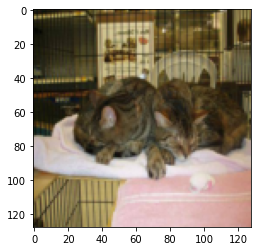

In [7]:
x,y = cats_dogs_dataset[59]
print("length of dataset is:",len(cats_dogs_dataset))
print("Y PROPERTIES", y)
print("X PROPERTIES", x.shape)
x = unnormelize(x)
plt.imshow(x.permute(1, 2, 0))

In [8]:
train_size = int(len(cats_dogs_dataset) *0.8)
val_size = len(cats_dogs_dataset) - train_size

train_ds, val_ds = random_split(cats_dogs_dataset, [train_size, val_size])
print(len(train_ds), len(val_ds))

20000 5000


In [9]:
batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, pin_memory=True)

torch.Size([64, 3, 128, 128]) torch.Size([64])
tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1])


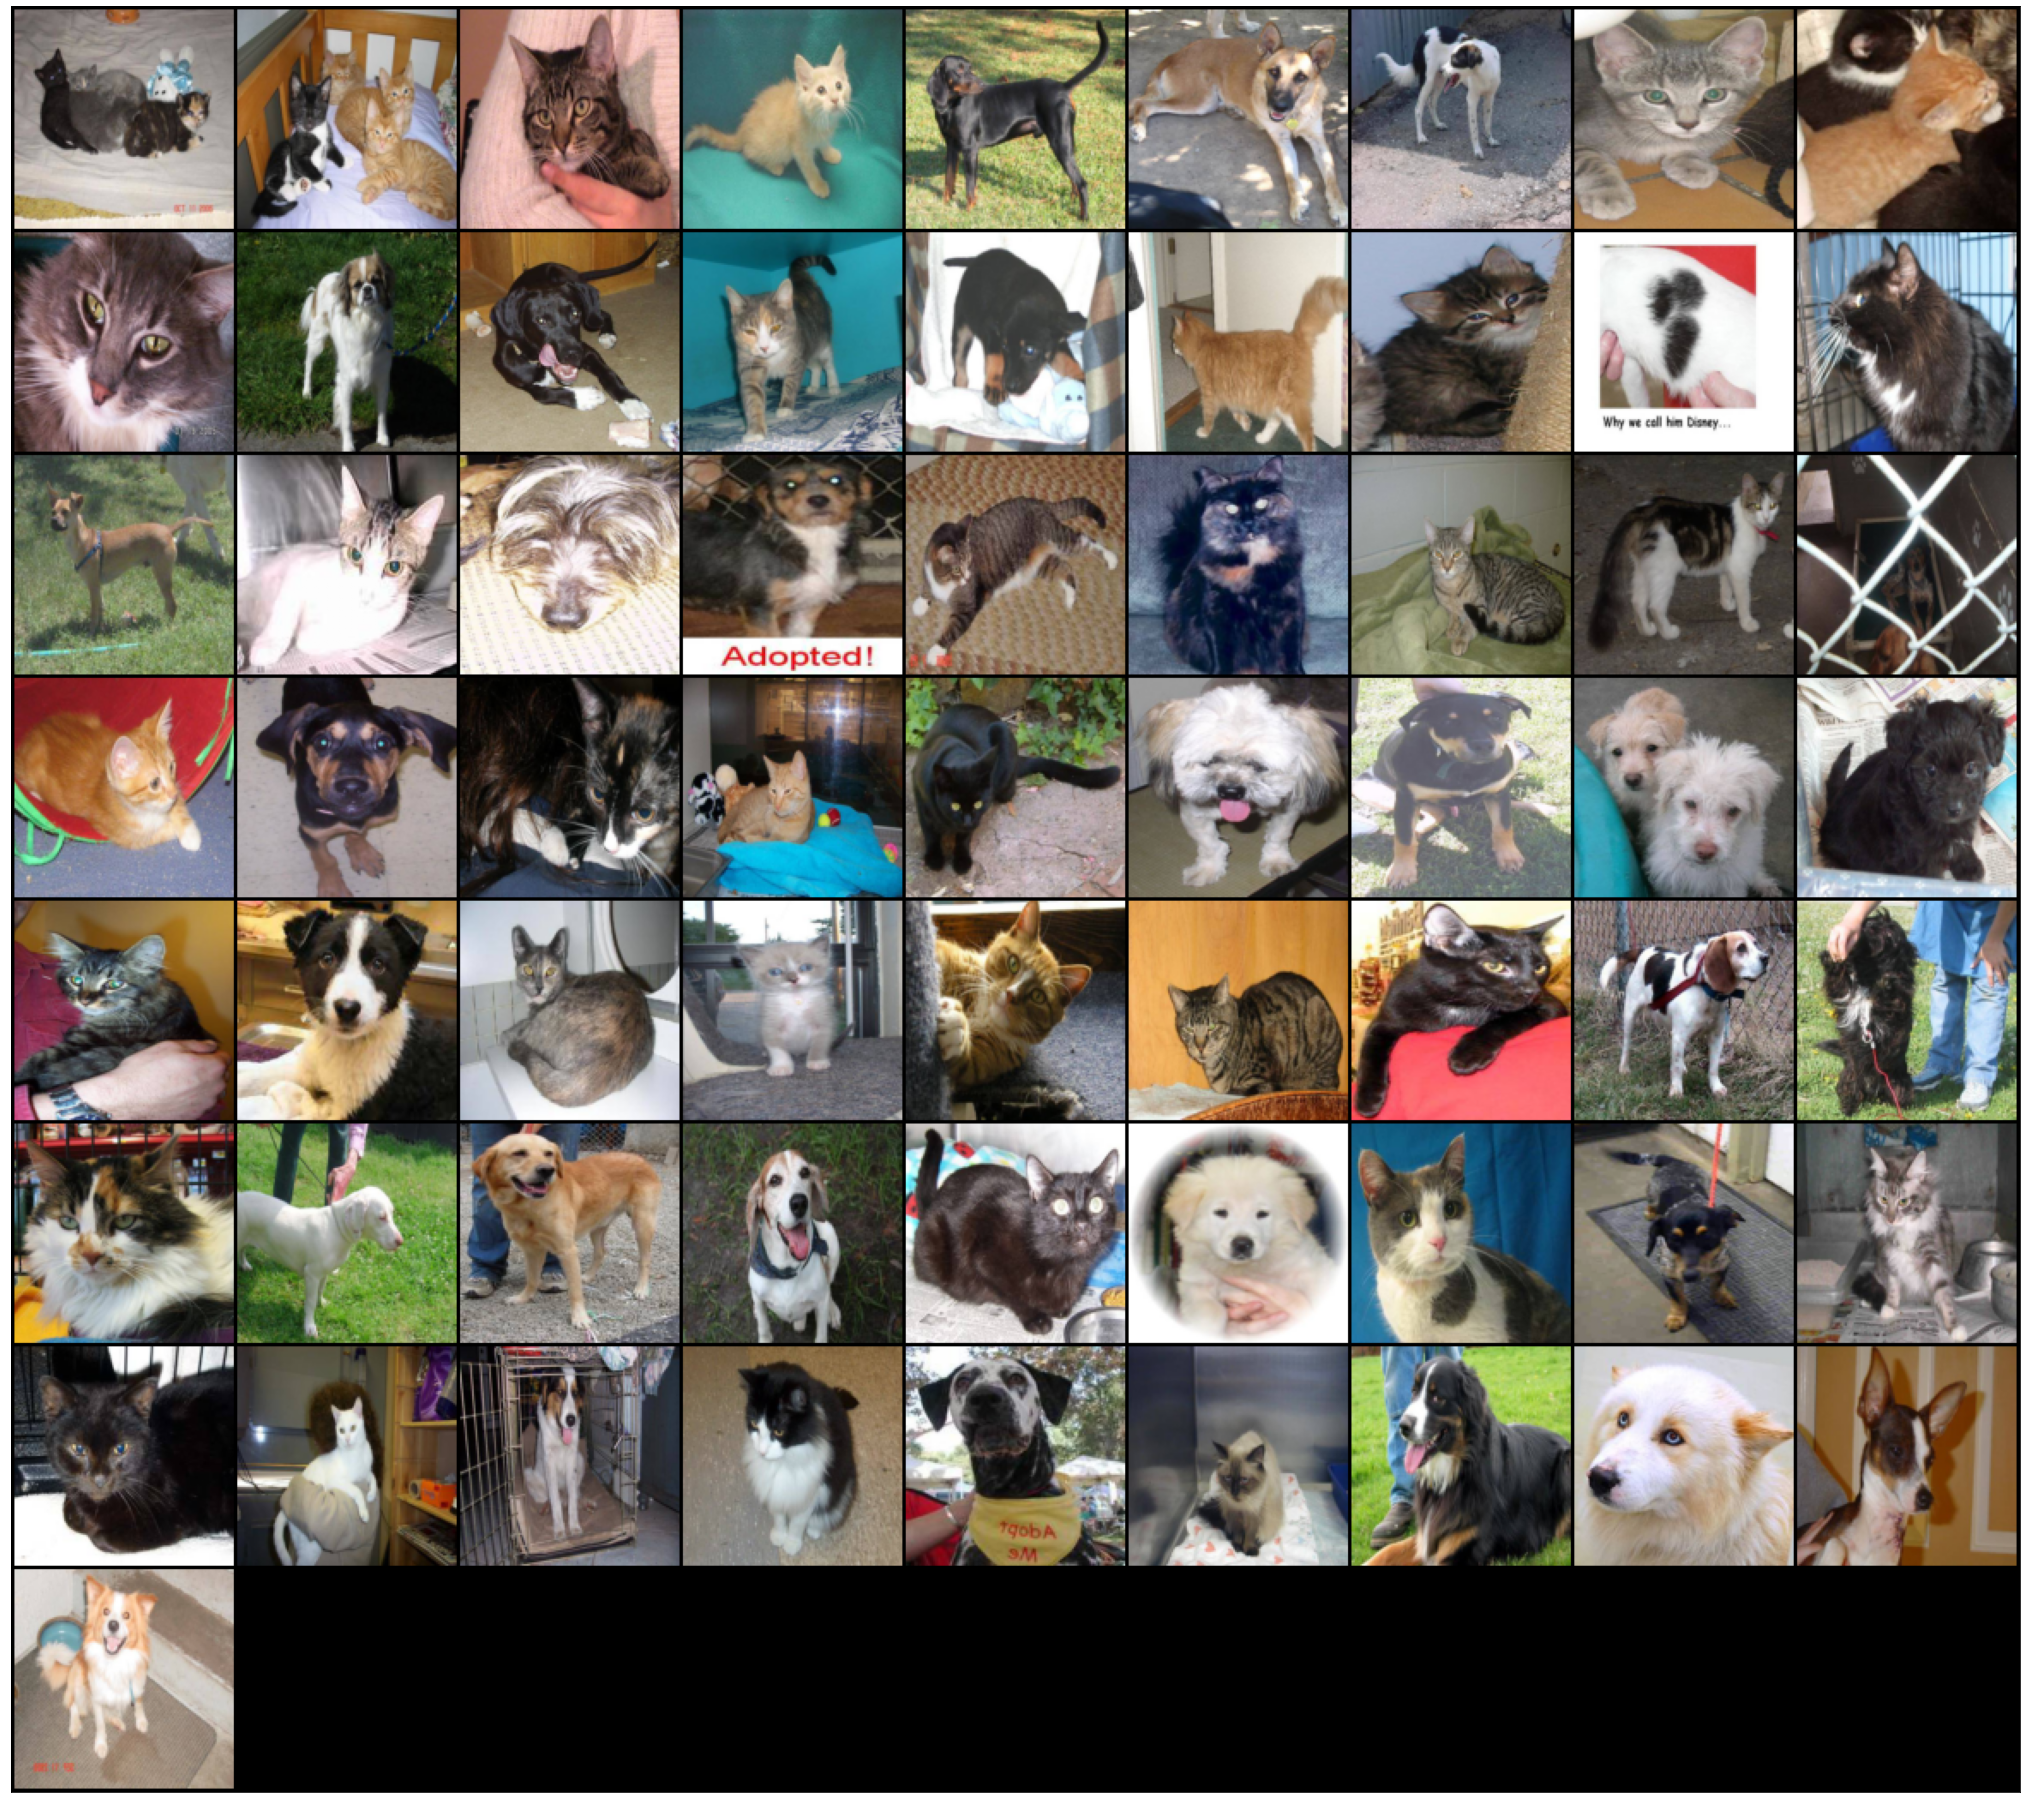

In [10]:
def show_batch(images, labels):
        print(labels)
        fig, ax = plt.subplots(figsize=(36, 36))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=9).permute(1, 2, 0))

train_iter = iter(train_dl)
images, labels = train_iter.next()
print(images.shape, labels.shape)
show_batch(unnormelize(images), labels)

In [11]:
class Model_cats_dogs(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) # input is (3 128 128), 16 output channels, 5x5 kernel 0 padding 1 stride->(16,126,126)
        self.rel1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2,2) # -> (16,63,63)
        self.conv2 = nn.Conv2d(16, 32, 3) # -> (32,61,61)
        self.rel2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2,2) # -> (32,30,30)
        self.conv3 = nn.Conv2d(32, 64, 3) # -> (64,28,28)
        self.rel3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2,2) # -> (64,14,14)

        self.fc1 = nn.Linear(64*14*14, 1024) #flattening.
        self.relfc1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 2048) 
        self.relfc2 = nn.ReLU()
        self.fc3 = nn.Linear(2048, 2048) 
        self.relfc3 = nn.ReLU()
        self.output = nn.Linear(2048, 2) #  2 out we're doing 2 classes (dog vs cat).


    def forward(self,bx):
        #print('a',bx.shape)
        bx = self.maxpool1(self.rel1(self.conv1(bx)))
        #print('b',bx.shape)
        bx = self.maxpool2(self.rel2(self.conv2(bx)))
        #print('c',bx.shape)
        bx = self.maxpool3(self.rel3(self.conv3(bx)))
        #print('d',bx.shape)
        bx = torch.flatten(bx, start_dim=1)
        #print('e',bx.shape)
        

        bx = self.relfc1(self.fc1(bx))
        bx = self.relfc2(self.fc2(bx))
        bx = self.relfc3(self.fc3(bx))
        bx = self.output(bx)

        return bx

In [12]:
from torchsummary import summary
model = Model_cats_dogs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#print(model)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             448
              ReLU-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 61, 61]           4,640
              ReLU-5           [-1, 32, 61, 61]               0
         MaxPool2d-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
           Linear-10                 [-1, 1024]      12,846,080
             ReLU-11                 [-1, 1024]               0
           Linear-12                 [-1, 2048]       2,099,200
             ReLU-13                 [-1, 2048]               0
           Linear-14                 [-

In [13]:
#
# HANDEL DEVICE
#
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    #return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
dataloaders = {'train': train_dl, 'val': val_dl}
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}
model = to_device(Model_cats_dogs(), device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
best_model = train_model(model, criterion, optimizer,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6829 Acc: 0.5577
val Loss: 0.6440 Acc: 0.6196

Epoch 1/9
----------
train Loss: 0.6016 Acc: 0.6741
val Loss: 0.5283 Acc: 0.7340

Epoch 2/9
----------
train Loss: 0.5179 Acc: 0.7423
val Loss: 0.5115 Acc: 0.7440

Epoch 3/9
----------
train Loss: 0.4585 Acc: 0.7846
val Loss: 0.4722 Acc: 0.7794

Epoch 4/9
----------
train Loss: 0.4142 Acc: 0.8131
val Loss: 0.4370 Acc: 0.7950

Epoch 5/9
----------
train Loss: 0.3747 Acc: 0.8347
val Loss: 0.4051 Acc: 0.8146

Epoch 6/9
----------
train Loss: 0.3267 Acc: 0.8569
val Loss: 0.3967 Acc: 0.8192

Epoch 7/9
----------
train Loss: 0.2759 Acc: 0.8846
val Loss: 0.4188 Acc: 0.8184

Epoch 8/9
----------
train Loss: 0.2230 Acc: 0.9099
val Loss: 0.3732 Acc: 0.8494

Epoch 9/9
----------
train Loss: 0.1716 Acc: 0.9346
val Loss: 0.3912 Acc: 0.8478

Training complete in 25m 40s
Best val Acc: 0.849400
